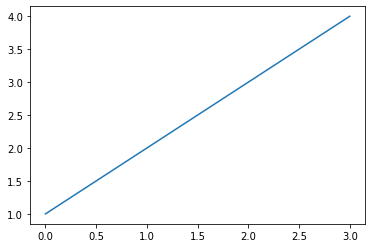

In [2]:
import matplotlib.pyplot as plt

plt.plot([1,2,3,4])

import pandas as pd
import numpy as np
import random
from quantnote import BacktestEngine, Strategy, DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque, namedtuple

In [3]:
db_path = '/Users/earen/Documents/earendil_git/DB/MainDB.db'

engine = BacktestEngine(db_path)

Loading DB...
DB loaded in 12.02 seconds
[initialize] is executed in 13.98 seconds


In [4]:
indicators = pd.read_csv('/Users/earen/Documents/earendil_git/DB/indicators.csv')
indicators = indicators[indicators.table=='SF1']
indicators = indicators[indicators.unittype != 'date (YYYY-MM-DD)']
indicators = indicators[indicators.unittype != 'text']
print(list(set(indicators.unittype)))
indicators

['USD', 'units', 'ratio', 'currency', 'currency/share', 'USD/share', '%']


,None,table,indicator,isfilter,isprimarykey,title,description,unittype
0,0,SF1,revenue,N,N,Revenues,[Income Statement] Amount of Revenue recognize...,currency
1,1,SF1,cor,N,N,Cost of Revenue,[Income Statement] The aggregate cost of goods...,currency
2,2,SF1,sgna,N,N,Selling General and Administrative Expense,[Income Statement] A component of [OpEx] repre...,currency
3,3,SF1,rnd,N,N,Research and Development Expense,[Income Statement] A component of [OpEx] repre...,currency
4,4,SF1,opex,N,N,Operating Expenses,[Income Statement] Operating expenses represen...,currency
...,...,...,...,...,...,...,...,...
100,100,SF1,workingcapital,N,N,Working Capital,[Metrics] Working capital measures the differe...,currency
101,101,SF1,fcfps,N,N,Free Cash Flow per Share,[Metrics] Free Cash Flow per Share is a valuat...,currency/share
102,102,SF1,bvps,N,N,Book Value per Share,[Metrics] Measures the ratio between [Equity] ...,currency/share
103,103,SF1,tbvps,N,N,Tangible Assets Book Value per Share,[Metrics] Measures the ratio between [Tangible...,currency/share


In [5]:
cap_norm = indicators[
    indicators.unittype.apply(lambda x:x in ['USD millions', 'USD', 'currency', 'units'])]
cap_norm = cap_norm[cap_norm.table=='SF1'].indicator.to_list()
cap_norm.remove('marketcap')
cap_norm


['revenue',
 'cor',
 'sgna',
 'rnd',
 'opex',
 'intexp',
 'taxexp',
 'netincdis',
 'consolinc',
 'netincnci',
 'netinc',
 'prefdivis',
 'netinccmn',
 'shareswa',
 'shareswadil',
 'capex',
 'ncfbus',
 'ncfinv',
 'ncff',
 'ncfdebt',
 'ncfcommon',
 'ncfdiv',
 'ncfi',
 'ncfo',
 'ncfx',
 'ncf',
 'sbcomp',
 'depamor',
 'assets',
 'cashneq',
 'investments',
 'investmentsc',
 'investmentsnc',
 'deferredrev',
 'deposits',
 'ppnenet',
 'inventory',
 'taxassets',
 'receivables',
 'payables',
 'intangibles',
 'liabilities',
 'equity',
 'retearn',
 'accoci',
 'assetsc',
 'assetsnc',
 'liabilitiesc',
 'liabilitiesnc',
 'taxliabilities',
 'debt',
 'debtc',
 'debtnc',
 'ebt',
 'ebit',
 'ebitda',
 'equityusd',
 'revenueusd',
 'netinccmnusd',
 'cashnequsd',
 'debtusd',
 'ebitusd',
 'ebitdausd',
 'sharesbas',
 'ev',
 'invcap',
 'equityavg',
 'assetsavg',
 'invcapavg',
 'tangibles',
 'fcf',
 'gp',
 'opinc',
 'workingcapital']

In [6]:
unary_list = indicators.indicator.to_list()
binary_list = ['B:add', 'B:sub', 'B:mul', 'B:div']

DQN_result_df = pd.DataFrame({
    'sharpe':[],
    'cagr':[],
    'vol':[],
    'tree':[]
})


len(unary_list)

105

#### Replaybuffer for agent

In [7]:
BATCH_SIZE = 1
LR = 10**(-4)
TAU = 10**(-3)
MAX_LEN = 5

class ReplayBuffer():
    def __init__(self):
        self.memory = deque(maxlen = 10000)
        self.experience = namedtuple("Experience",
                                    field_names=[
                                        'state', 'action', 'reward',
                                        'next_state', 'done'
                                    ])
        
    def add(self, state, action, reward, next_state, done):
        new_exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(new_exp)
        
    def sample(self):
        experiences = random.sample(self.memory, k = BATCH_SIZE)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

#### DQN to evalute Q-table

In [8]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.ffn_state_to_embed = nn.Linear(MAX_LEN, 128)
        
        self.ffn_embed_to_unary = nn.Linear(128, 32)
        self.ffn_embed_to_binary = nn.Linear(128, 32)
        
        self.ffn_unary_to_logit = nn.Linear(32, 105)
        self.ffn_binary_to_logit = nn.Linear(32, 4)
        
    def forward(self, x):
        x = F.relu(self.ffn_state_to_embed(x))
        
        unary = F.relu(self.ffn_embed_to_unary(x))
        binary = F.relu(self.ffn_embed_to_binary(x))
        
        unary = torch.mul(F.softmax(self.ffn_unary_to_logit(unary), dim=1), 3)
        binary = torch.mul(F.softmax(self.ffn_binary_to_logit(binary), dim=1), 3)
        
        y = torch.cat([unary, binary], axis=1)
        
        return y

#### Agent

In [9]:
class Agent():
    def __init__(self):
        self.tau = TAU
        self.lr = LR
        
        self.state_size = MAX_LEN
        self.binary_action_size = len(binary_list)
        self.unary_action_size = len(unary_list)
        
        self.qnetwork_local = QNetwork()
        self.qnetwork_target = QNetwork()
        self.qnetwork_target.eval()
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.lr)
        self.memory = ReplayBuffer()
        self.t = 0
        
    def step(self, state, action, reward, next_state, done):
        self.t += 1
        self.memory.add(state, action, reward, next_state, done)
        
        if self.t%1 == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def act(self, state, eps):
        state = np.array(state)
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()
            
            action = np.argmax(action_values.cpu().data.numpy())
            
        else:
            token = np.random.rand()
            if token > 0:
                action = random.choice(np.arange(len(unary_list)))
            else:
                action = len(unary_list) + random.choice(np.arange(len(binary_list)))
            
        return action
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        
        with torch.no_grad():
            next_action_rewards_local = self.qnetwork_local(next_states)
            greedy_action_local = next_action_rewards_local.max(dim = 1, keepdim = True)[1]
            
            next_action_rewards_target = self.qnetwork_target(next_states)
            target_rewards = next_action_rewards_target.gather(1, greedy_action_local)
            
            target_rewards = rewards + (target_rewards * (1 - dones))
            
        expected_action_rewards = self.qnetwork_local(states) 
        expected_rewards = expected_action_rewards.gather(1, actions) 
        
        loss = F.mse_loss(expected_rewards, target_rewards)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        for target_param, local_param in zip(
            self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
        
        
class Environment():
    def __init__(self, engine):
        self.engine = engine
        self.state = [-1]*MAX_LEN
        
    def step(self, action, DQN_result_df):
        
        next_state = self.state.copy()
        if -1 in next_state:
            idx = next_state.index(-1)
            next_state[idx] = action
        else:
            next_state = [-1]*MAX_LEN
            
        checksum = 1
        for elem in next_state:
            if elem == -1:
                pass
            elif elem < len(unary_list):
                checksum -= 1
            elif elem >= len(unary_list):
                checksum += 1
                
        self.state = next_state
        
        if checksum == 0:
            done = True
            tree = self.convert_state_to_tree(next_state)
            strategy = myStrategy(tree)
            engine.run_backtest(strategy, sdate='2016-06-01', edate='2021-08-31', period='Q')
            engine.stat(bench=None)
            sharpe = engine.stat_dic['sharpe']
            cagr = engine.stat_dic['cagr']
            vol = engine.stat_dic['vol']
            reward = sharpe
            DQN_result_df = DQN_result_df.append({
                'sharpe':sharpe,
                'cagr':cagr,
                'vol':vol,
                'tree':tree
                }, ignore_index=True)
            DQN_result_df.to_parquet('DQN_result_df.parquet')
        else:
            reward = 0
            if next_state == [-1]*MAX_LEN:
                reward = -1
            done = False
        
        return reward, next_state, done, DQN_result_df
    
    def convert_state_to_tree(self, state):
        tree = []
        for x in state:
            if x == -1:
                pass
            elif x < len(unary_list):
                tree.append(unary_list[x])
            elif x >= len(unary_list):
                tree.append(binary_list[x-len(unary_list)])
                
        return tree

#### Environment

In [10]:
class Environment():
    def __init__(self, engine):
        self.engine = engine
        self.state = [-1]*MAX_LEN
        
    def step(self, action, DQN_result_df):
        
        next_state = self.state.copy()
        if -1 in next_state:
            idx = next_state.index(-1)
            next_state[idx] = action
        else:
            next_state = [-1]*MAX_LEN
            
        checksum = 1
        for elem in next_state:
            if elem == -1:
                pass
            elif elem < len(unary_list):
                checksum -= 1
            elif elem >= len(unary_list):
                checksum += 1
                
        self.state = next_state
        
        if checksum == 0:
            done = True
            tree = self.convert_state_to_tree(next_state)
            strategy = myStrategy(tree)
            engine.run_backtest(strategy, sdate='2016-06-01', edate='2021-08-31', period='Q')
            engine.stat(bench=None)
            sharpe = engine.stat_dic['sharpe']
            cagr = engine.stat_dic['cagr']
            vol = engine.stat_dic['vol']
            reward = sharpe
            DQN_result_df = DQN_result_df.append({
                'sharpe':sharpe,
                'cagr':cagr,
                'vol':vol,
                'tree':tree
                }, ignore_index=True)
            DQN_result_df.to_parquet('DQN_result_df.parquet')
        else:
            reward = 0
            if next_state == [-1]*MAX_LEN:
                reward = -1
            done = False
        
        return reward, next_state, done, DQN_result_df
    
    def convert_state_to_tree(self, state):
        tree = []
        for x in state:
            if x == -1:
                pass
            elif x < len(unary_list):
                tree.append(unary_list[x])
            elif x >= len(unary_list):
                tree.append(binary_list[x-len(unary_list)])
                
        return tree
    
    
class myStrategy(Strategy):
    def __init__(self, tree):
        super().__init__()
        self.tree = tree
        print(tree)
                
    def compute_factor_from_tree(self, universe_list):
        tree = self.tree.copy()
        ops = []
        inputs = []

        while tree:
            x = tree.pop()

            if x[0]=='B': 
                ops.append(x)
            else:
                x = self.compute_factor_series(universe_list, x, type='rank')
                inputs.append(x)

            if len(inputs) >= 2 and len(ops) >= 1:
                x1 = inputs.pop()
                x2 = inputs.pop()
                binary = ops.pop()

                if binary == 'B:add': x = x1 + x2
                elif binary == 'B:sub': x = x1 - x2
                elif binary == 'B:mul': x = x1 * x2
                elif binary == 'B:div': x = x1 / x2
                
                inputs.append(x)
                
        assert len(ops) == 0 and len(inputs) == 1
        x = inputs.pop()
        return x

    
    def compute_target(self, universe_list):
        target_weight = { }
        
        factor_series = self.compute_factor_from_tree(universe_list)
        
        factor_series = self.transform_series(factor_series, 'rank', universe_list)-0.5
        
        for ticker in factor_series.index:
            weight = factor_series[ticker]
            if weight > 0:
                target_weight[ticker] = weight
                
        assert len(target_weight) >= 5
        
        target_weight = self.normalize(target_weight)
        return target_weight

    def custom_factor(self, ticker, ftype):
        if ftype == 'marketcap':
            return self.get_value('metric',ticker,'marketcap')
        else:
            if ftype in cap_norm:
                x = self.get_value('fundamentals',ticker,ftype)/self.get_value('fundamentals',ticker,'marketcap')
            else:
                x = self.get_value('fundamentals',ticker,ftype)
            return x
        

In [11]:
def training(max_epi, max_t=MAX_LEN, eps_max=0.5, eps_decay=1.0):
    score_list = []
    score_mean_list = []
    score_window = deque(maxlen = 10)
    eps = eps_max
    
    for epi in range(max_epi):
        state = [-1]*MAX_LEN
        score = 0
        print('\n')
        for t in range(max_t):
            env.state = state
            action = agent.act(state, eps).astype(int)
            if epi == 0:
                DQN_result_df = pd.DataFrame({
                    'sharpe':[],
                    'cagr':[],
                    'vol':[],
                    'tree':[]
                })
            reward, next_state, done, DQN_result_df = env.step(action, DQN_result_df)
            print(f'state={state}, action={action},reward={reward}, next_state={next_state}, done={done}')
            
#             next_state = env_info.vector_observations[0]
#             reward = env_info.rewards[0]
#             done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done : 
                break
                
        score_list.append(score)
        score_window.append(score)
        score_mean_list.append(np.mean(score_window))
        
        eps = eps * eps_decay
        
        if epi % 1 == 0:
            print(f'epi={epi}, score={score_mean_list[-1]}')
            
#         if score_mean_list[-1] > 13.0:
#             print(epi, score_mean_list[-1])
#             print('success!')
#             torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
#             break
            
    return score_list, score_mean_list

In [16]:
agent = Agent()
env = Environment(engine)


score_list, score_mean_list = training(max_epi=100)



state=[-1, -1, -1, -1, -1], action=105,reward=0, next_state=[105, -1, -1, -1, -1], done=False
state=[105, -1, -1, -1, -1], action=71,reward=0, next_state=[105, 71, -1, -1, -1], done=False
state=[105, 71, -1, -1, -1], action=105,reward=0, next_state=[105, 71, 105, -1, -1], done=False
state=[105, 71, 105, -1, -1], action=105,reward=0, next_state=[105, 71, 105, 105, -1], done=False
state=[105, 71, 105, 105, -1], action=51,reward=0, next_state=[105, 71, 105, 105, 51], done=False
epi=0, score=0.0


['sharesbas']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.687 / time elapsed:21.3 ===
[run_backtest] is executed in 21.60 seconds
state=[-1, -1, -1, -1, -1], action=67,reward=0.5523687028872849, next_state=[67, -1, -1, -1, -1], done=True
epi=1, score=0.27618435144364245


['taxexp']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.646 / time elapsed:20.8 ===
[run_backtest] is exe

Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:2.205 / time elapsed:19.9 ===
[run_backtest] is executed in 20.26 seconds
state=[-1, -1, -1, -1, -1], action=100,reward=0.8313299637821069, next_state=[100, -1, -1, -1, -1], done=True
epi=18, score=0.6243059384278374


state=[-1, -1, -1, -1, -1], action=106,reward=0, next_state=[106, -1, -1, -1, -1], done=False
state=[106, -1, -1, -1, -1], action=60,reward=0, next_state=[106, 60, -1, -1, -1], done=False
state=[106, 60, -1, -1, -1], action=106,reward=0, next_state=[106, 60, 106, -1, -1], done=False
state=[106, 60, 106, -1, -1], action=107,reward=0, next_state=[106, 60, 106, 107, -1], done=False
state=[106, 60, 106, 107, -1], action=107,reward=0, next_state=[106, 60, 106, 107, 107], done=False
epi=19, score=0.5240478161502122


state=[-1, -1, -1, -1, -1], action=106,reward=0, next_state=[106, -1, -1, -1, -1], done=False
state=[106, -1, -1, -1, -1], action=106,reward=0, next_state=[106, 

Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:2.104 / time elapsed:20.5 ===
[run_backtest] is executed in 20.81 seconds
state=[-1, -1, -1, -1, -1], action=14,reward=0.8193907778531331, next_state=[14, -1, -1, -1, -1], done=True
epi=35, score=0.4231240697173522


['assetsc']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.787 / time elapsed:19.6 ===
[run_backtest] is executed in 19.88 seconds
state=[-1, -1, -1, -1, -1], action=47,reward=0.6291054857745292, next_state=[47, -1, -1, -1, -1], done=True
epi=36, score=0.4860346182948052


state=[-1, -1, -1, -1, -1], action=105,reward=0, next_state=[105, -1, -1, -1, -1], done=False
state=[105, -1, -1, -1, -1], action=91,reward=0, next_state=[105, 91, -1, -1, -1], done=False
['B:add', 'pe', 'ebitda']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.830 / time elapsed:20.9 ===
[

Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:2.716 / time elapsed:21.0 ===
[run_backtest] is executed in 21.26 seconds
state=[105, 106, 28, 98, -1], action=62,reward=0.9689206899444259, next_state=[105, 106, 28, 98, 62], done=True
epi=53, score=0.4853452605708563


['retearn']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.616 / time elapsed:20.3 ===
[run_backtest] is executed in 20.61 seconds
state=[-1, -1, -1, -1, -1], action=45,reward=0.48240970056317606, next_state=[45, -1, -1, -1, -1], done=True
epi=54, score=0.4726621740597878


state=[-1, -1, -1, -1, -1], action=105,reward=0, next_state=[105, -1, -1, -1, -1], done=False
state=[105, -1, -1, -1, -1], action=15,reward=0, next_state=[105, 15, -1, -1, -1], done=False
['B:add', 'shareswa', 'netinc']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.663 / time elapsed

=== date:2021-08-31 00:00:00 / total_asset:2.577 / time elapsed:20.1 ===
[run_backtest] is executed in 20.42 seconds
state=[105, 8, 106, 91, -1], action=45,reward=0.9398694129485999, next_state=[105, 8, 106, 91, 45], done=True
epi=71, score=0.49661870692483684


state=[-1, -1, -1, -1, -1], action=105,reward=0, next_state=[105, -1, -1, -1, -1], done=False
state=[105, -1, -1, -1, -1], action=106,reward=0, next_state=[105, 106, -1, -1, -1], done=False
state=[105, 106, -1, -1, -1], action=47,reward=0, next_state=[105, 106, 47, -1, -1], done=False
state=[105, 106, 47, -1, -1], action=0,reward=0, next_state=[105, 106, 47, 0, -1], done=False
['B:add', 'B:sub', 'assetsc', 'revenue', 'consolinc']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.957 / time elapsed:18.6 ===
[run_backtest] is executed in 18.88 seconds
state=[105, 106, 47, 0, -1], action=8,reward=0.7658327135739573, next_state=[105, 106, 47, 0, 8], done=True
epi=72, score=0.52

Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:2.465 / time elapsed:22.0 ===
[run_backtest] is executed in 22.28 seconds
state=[-1, -1, -1, -1, -1], action=104,reward=0.8931902300580365, next_state=[104, -1, -1, -1, -1], done=True
epi=89, score=0.4292009743448671


state=[-1, -1, -1, -1, -1], action=105,reward=0, next_state=[105, -1, -1, -1, -1], done=False
state=[105, -1, -1, -1, -1], action=79,reward=0, next_state=[105, 79, -1, -1, -1], done=False
['B:add', 'fcf', 'netmargin']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:2.107 / time elapsed:22.4 ===
[run_backtest] is executed in 22.72 seconds
state=[105, 79, -1, -1, -1], action=84,reward=0.8221453545642783, next_state=[105, 79, 84, -1, -1], done=True
epi=90, score=0.45618339783846046


['inventory']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:1.667 / time elapsed

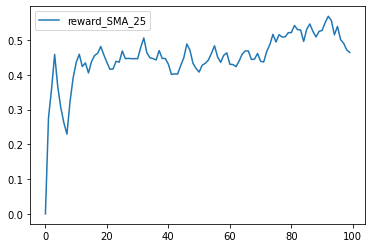

In [25]:
score_series = pd.Series(score_list)

#plt.plot(score_series)
plt.plot(score_series.rolling(25, min_periods=0).mean())
plt.legend(['reward_SMA_25'])